This notebook demonstrates how to approximate solutions using the Finite Element Method in a one-dimensional setting. The problem setup is the same as defined in the UCL course MATH0092: Variational Methods for Partial Differential Equations.

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import logging
import os
import sympy as sp

In [170]:
handler = logging.StreamHandler()
logger = logging.getLogger(__name__)
logger.setLevel(os.environ.get("LOGLEVEL", "INFO"))
logger.addHandler(handler)

In [171]:
# Pick the number of elements

N = 9
h = 1/(N+1)
nodes = np.linspace(0, 1, N+2)

nodes

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [172]:
# Implement the finite element basis functions

def phi(i, x, deriv=False):
    """Linear piecewise affine function finite element basis
    i: integer between 0 and N+1
    x: real number between 0 and 1
    deriv: True or False to indicate whether function is basis or its derivative
    """
    try:
        if not isinstance(i, int):
            raise TypeError(f"Variable 'i' must be an integer, got {i}")
        if not (0 <= i <= N+1):
            raise ValueError(f"Variable 'i' must be an integer between 0 and N+1, got {i}")

        if deriv == False:
            if i == 0:
                if nodes[0] <= x <= nodes[1]:
                    return 1 - (x-nodes[i])/h
                else:
                    return 0
            elif i == N+1:
                if nodes[-2] <= x <= nodes[-1]:
                    return 1 + (x-nodes[i])/h
                else:
                    return 0
            if 0 < i < N+1:
                if nodes[i-1] <= x <= nodes[i]:
                    return 1 + (x-nodes[i])/h
                elif nodes[i] < x <= nodes[i+1]:
                    return 1 - (x-nodes[i])/h
                else:
                    return 0

        if deriv:
            if i == 0:
                if nodes[0] <= x <= nodes[1]:
                    return -1/h
                else:
                    return 0
            if i == N+1:
                if nodes[-2] <= x <= nodes[-1]:
                    return 1/h
                else:
                    return 0
            if 0 < i < N+1:
                if nodes[i-1] <= x <= nodes[i]:
                    return 1/h
                elif nodes[i] < x <= nodes[i+1]:
                    return -1/h
                else:
                    return 0

    except TypeError as err:
        logger.error(f"TypeError: {err}")
    except ValueError as err:
        logger.error(f"ValueError: {err}")
    except Exception as err:
        logger.error(f"Error: {err}")

def psi(i, x, deriv=False):
    """Quadratic piecewise affine function finite element basis
    i: integer between 1 and N+1
    x: real number between 0 and 1
    deriv: True or False to indicate whether function is basis or its derivative
    """
    try:
        if not isinstance(i, int):
            raise TypeError(f"Variable 'i' must be an integer, got {i}")
        if not (1 <= i <= N+1):
            raise ValueError(f"Variable 'i' must be an integer between 1 and N+1, got {i}")

        if deriv == False:
            if nodes[i-1] <= x <= nodes[i]:
                return (x-nodes[i-1])*(x-nodes[i])/2
            else:
                return 0

        if deriv:
            if nodes[i-1] <= x <= nodes[i]:
                return x-(nodes[i-1]+nodes[i])/2
            else:
                return 0

    except TypeError as err:
        logger.error(f"TypeError: {err}")
    except ValueError as err:
        logger.error(f"ValueError: {err}")
    except Exception as err:
        logger.error(f"Error: {err}")


Define parameters of the equation:

$ a(x)u'' + b(x) u' + c(x)u = f(x)$

$a(x), b(x), c(x), f(x)$ are extended real valued functions where $a, b, c \in L^{\infty}$ and $f \in L^2$

In [173]:
def a_func(x):
    return -1

def b_func(x):
    return 0

def c_func(x):
    return 1

def f_func(x):
    return 1

In [174]:
class ODE:
    def __init__(self, a, b, c, f):
        self.a = a
        self.b = b
        self.c = c
        self.f = f

    def display_equation(self):
        """
        Display the differential equation using LaTeX formatting.
        """
        x = sp.symbols('x')
        y = sp.Function('y')(x)
        a_latex = sp.latex(self.a(x))
        b_latex = sp.latex(self.b(x))
        c_latex = sp.latex(self.c(x))
        f_latex = sp.latex(self.f(x))
        
        # Construct the ODE in terms of sympy expressions
        ode_lhs = self.a(x)*sp.diff(y, x, x) + self.b(x)*sp.diff(y, x) + self.c(x)*y
        ode_rhs = self.f(x)
        equation = sp.Eq(ode_lhs, ode_rhs)
        
        try:
            from IPython.display import display, Math
            display(Math(sp.latex(equation)))
        
        except ImportError:
            print(f"LaTeX equation: {sp.latex(equation)}")
    

In [175]:
# Initialize the ODE with these functions
ode = ODE(a_func, b_func, c_func, f_func)

# Display the LaTeX equation
ode.display_equation()


<IPython.core.display.Math object>

In [177]:
class DirichletBC:
    def __init__(self, g0=None, g1=None):
        self.leftbc = g0
        self.rightbc = g1

class LeftDirichletBC(DirichletBC):
    def __init__(self, g0):
        super().__init__(g0=g0)

    def display_equation(self):
        """
        Display the left boundary condition using LaTeX formatting.
        """
        y = sp.Function('y')
        equation = sp.Eq(y(0), self.leftbc)
        
        try:
            from IPython.display import display, Math
            display(Math(sp.latex(equation)))
        except ImportError:
            print(f"LaTeX equation: {sp.latex(equation)}")

    def apply(self, f_array, A=None, ode=None, poly=phi, last=None):
        def bilinear_form(u,i,v,j):
            return integrate.quad(lambda x: -1*ode.a(x)*u(i,x,deriv=True)*v(j,x,deriv=True) + ode.b(x)*u(i,x,deriv=True)*v(j,x) + ode.c(x)*u(i,x)*v(j,x), 0, 1)[0]
        def u_hat(i,x,deriv=False):
            if deriv == False:
                return self.leftbc*phi(0,x)
            if deriv:
                return self.leftbc*phi(0,x,deriv=True)
        
        f_array[0] += -bilinear_form(u_hat,1,poly,1)

class RightDirichletBC(DirichletBC):
    def __init__(self, g1):
        super().__init__(g1=g1)

    def display_equation(self):
        """
        Display the right boundary condition using LaTeX formatting.
        """
        y = sp.Function('y')
        equation = sp.Eq(y(1), self.rightbc)
        
        try:
            from IPython.display import display, Math
            display(Math(sp.latex(equation)))
        except ImportError:
            print(f"LaTeX equation: {sp.latex(equation)}")

    def apply(self, f_array, A=None, ode=None, poly=phi, last=None):
        def bilinear_form(u,i,v,j):
            return integrate.quad(lambda x: -1*ode.a(x)*u(i,x,deriv=True)*v(j,x,deriv=True) + ode.b(x)*u(i,x,deriv=True)*v(j,x) + ode.c(x)*u(i,x)*v(j,x), 0, 1)[0]
        def u_hat(i,x,deriv=False):
            if deriv == False:
                return self.rightbc*phi(N+1,x)
            if deriv:
                return self.rightbc*phi(N+1,x,deriv=True)
        
        f_array[last] += -bilinear_form(u_hat,N,poly,N)

In [178]:
bc1 = LeftDirichletBC(0)
bc2 = RightDirichletBC(0)
bc1.display_equation()
bc2.display_equation()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [179]:
class RobinBC:
    def __init__(self, g0=None, g1=None, beta=0):
        self.leftbc = g0
        self.rightbc = g1
        self.beta = beta

class LeftRobinBC(RobinBC):
    def __init__(self, g0, beta=0):
        super().__init__(g0=g0, beta=beta)

    def display_equation(self):
        """
        Display the left boundary condition using LaTeX formatting.
        """
        x = sp.symbols('x')
        y = sp.Function('y')(x)
        lhs = -sp.diff(y, x).subs(x, 0) + self.beta*y.subs(x, 0)
        equation = sp.Eq(lhs, -1*self.leftbc)
        
        try:
            from IPython.display import display, Math
            display(Math(sp.latex(equation)))
        except ImportError:
            print(f"LaTeX equation: {sp.latex(equation)}")
 
    def apply(self, f_array, A, ode, poly=None, last=None):
        A[0,0] += -ode.a(0)*self.beta*phi(0,0)*phi(0,0) # Only phi_0 is non zero at x=0
        f_array[0] += ode.a(0)*self.leftbc*phi(0,0) # Only phi_0 is non zero at x=0

class RightRobinBC(RobinBC):
    def __init__(self, g1, beta=0):
        super().__init__(g1=g1, beta=beta)

    def display_equation(self):
        """
        Display the left boundary condition using LaTeX formatting.
        """
        x = sp.symbols('x')
        y = sp.Function('y')(x)
        lhs = sp.diff(y, x).subs(x, 1) + self.beta*y.subs(x, 1)
        equation = sp.Eq(lhs, self.rightbc)
        
        try:
            from IPython.display import display, Math
            display(Math(sp.latex(equation)))
        except ImportError:
            print(f"LaTeX equation: {sp.latex(equation)}")

    def apply(self, f_array, A, ode, poly, last):
        A[last,last] += -ode.a(1)*self.beta*phi(N+1,1)*phi(N+1,1) # Only phi_{N+1} is non zero at x=1 CHANGE TO N+1 OR SOMETHING SINCE FOR POLY IT IS
        f_array[last] += -ode.a(1)*self.rightbc*phi(N+1,1) # Only phi_{N+1} is non zero at x=1

In [180]:
bc3 = LeftRobinBC(1,1)
bc4 = RightRobinBC(0,1)
bc3.display_equation()
bc4.display_equation()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [192]:
class FEMSolver:
    def __init__(self, ode, leftbc, rightbc, poly_order=0):
        self.ode = ode
        self.leftbc = leftbc
        self.rightbc = rightbc
        self.poly_order = poly_order # 0 for linear and 1 for quadratic

    # BASE (Homogenous Dirichlet)
    def solve(self):
        quadratic = self.poly_order*(N+1)
        k = N+2 + quadratic
        k -= int(isinstance(self.leftbc, LeftDirichletBC)) + int(isinstance(self.rightbc, RightDirichletBC))
        testvariable = N+1 if isinstance(self.rightbc, RightDirichletBC) else N+2
        size = range(1 if isinstance(self.leftbc, LeftDirichletBC) else 0, N+1 if isinstance(self.rightbc, RightDirichletBC) else N+2) # (1,N+1) if dirichlet (0,N+2) if robin
        size2 = range(1 if isinstance(self.leftbc, LeftDirichletBC) else 0, N if isinstance(self.rightbc, RightDirichletBC) else N+1) # (1,N) if dirichlet (0,N+1) if robin
        size3 = range(1 if isinstance(self.leftbc, LeftDirichletBC) else 0, N+1 + quadratic if isinstance(self.rightbc, RightDirichletBC) else N+2 + quadratic) # (1,2N+2) if dirichlet (0,2N+3) if robin
        size4 = range(1 if isinstance(self.leftbc, LeftDirichletBC) else 0, N + quadratic if isinstance(self.rightbc, RightDirichletBC) else N+1 + quadratic) # (1,2N+1) if dirichlet (0,2N+2) if robin
        
        def bilinear_form(u,i,v,j):
            return integrate.quad(lambda x: -1*ode.a(x)*u(i,x,deriv=True)*v(j,x,deriv=True) + ode.b(x)*u(i,x,deriv=True)*v(j,x) + ode.c(x)*u(i,x)*v(j,x), 0, 1)[0]
        
        def linear_functional(v,i):
            return integrate.quad(lambda x: ode.f(x)*v(i,x), 0, 1)[0]
        
        def sigma(i,x,deriv=False):
            if i < testvariable:
                return phi(i,x,deriv=deriv)
            else:
                return psi(i+1-testvariable,x,deriv=deriv)
        
        A = np.zeros((k, k))
        f_array = np.empty(k)

        for index, i in enumerate(size3):
            A[index,index] = bilinear_form(sigma,i,sigma,i) # [0,N-1] Dirichlet with [1,N] phi , [0,N+1] robin with same phi

        for index, i in enumerate(size4):
            A[index,index+1] = bilinear_form(sigma,i+1,sigma,i)
            A[index+1,index] = bilinear_form(sigma,i,sigma,i+1)

        for index, i in enumerate(size3):
            f_array[index] = linear_functional(sigma,i)

        self.leftbc.apply(f_array, A, self.ode, phi if quadratic == 0 else sigma, len(size)-1)
        self.rightbc.apply(f_array, A, self.ode, phi if quadratic == 0 else sigma, len(size)-1)

        U = np.linalg.solve(A, f_array)

        def u_h(x):
                approx = 0
                for index, i in enumerate(size):
                    approx += U[index]*phi(i,x)
                if quadratic != 0:
                    for i in range(1,N+2):
                        approx += U[len(size)+i-1]*psi(i,x)
                if isinstance(self.leftbc, LeftDirichletBC):
                    approx += self.leftbc.leftbc*phi(0,x)
                if isinstance(self.rightbc, RightDirichletBC):
                    approx += self.rightbc.rightbc*phi(N+1,x)
                return approx

        xes = np.linspace(0,1,200)
        plt.plot(xes, [u_h(x) for x in xes], label = "FE Solution")

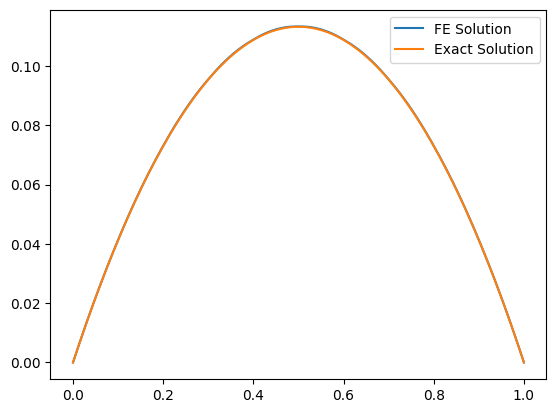

In [194]:
bc1 = LeftDirichletBC(0)
bc2 = RightDirichletBC(0) 
solution = FEMSolver(ode,bc1,bc2,1)
solution.solve()
def u_exact(x):
            e = np.e
            return ((1/e-1)/(e-1/e)*e**x-(e-1)/(e-1/e)*e**(-x))+1 # Solved analytically
            # return -e**(x-1)/2-e**(-x)+1
xes = np.linspace(0,1,200)
plt.plot(xes, [u_exact(x) for x in xes], label = "Exact Solution")
plt.legend()

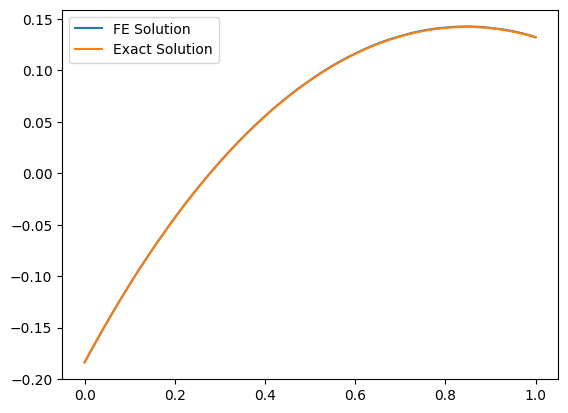

In [196]:
bc3 = LeftRobinBC(1,1)
bc4 = RightRobinBC(0,1)
solution = FEMSolver(ode,bc3,bc4,1)
solution.solve()

def u_exact(x):
            e = np.e
            return -e**(x-1)/2-e**(-x)+1

xes = np.linspace(0,1,200)
plt.plot(xes, [u_exact(x) for x in xes], label = "Exact Solution")
plt.legend()

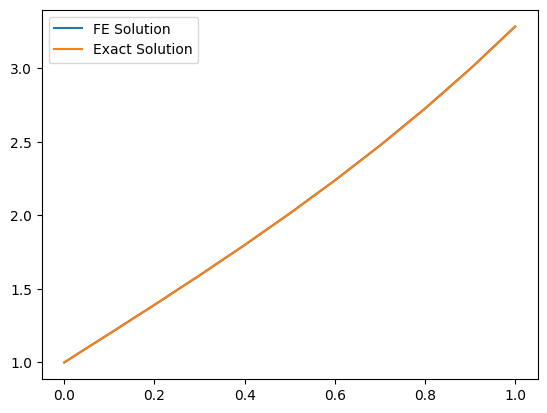

In [198]:
bc5 = LeftDirichletBC(1)
bc6 = RightRobinBC(3,0)
solution1 = FEMSolver(ode, bc5, bc6, 1)
solution1.solve()

def u_exact(x):
            e = np.e
            return (-3*e**(1-x)+3*e**(x+1)+1+e**2)/(1+e**2)
xes = np.linspace(0,1,200)
plt.plot(xes, [u_exact(x) for x in xes], label = "Exact Solution")
plt.legend()

Define parameters of the equation:

$ a(x)u'' + b(x) u' + c(x)u = f(x)$

$a(x), b(x), c(x), f(x)$ are extended real valued functions where $a, b, c \in L^{\infty}$ and $f \in L^2$

In [77]:
def a(x):
    return -1

def b(x):
    return 0

def c(x):
    return 1

def f(x):
    return 1

# Dirichlet Boundary Conditions

Let $u(0)=g_0$ and $u(1)=g_1$

Let the finite element subspace $V_h$ be the piecewise linear functions in $H^1_0(0,1)$ so it does not include the basis functions $\phi_0$ and $\phi_{N+1}$ and has dimension $N$.

Seek a solution in the form $u_h=u_0 + \hat{u}$ where $u_0 \in V_h$ and $\hat{u} \in H^1(0,1)$ satisfies the boundary conditions $\hat{u}(0) = g_0$ and $\hat{u}(1) = g_1$.

An easy way to fulfill this condition is by defining: </br>

$\hat{u}(x) = g_0\phi_0 + g_1\phi_{N+1}$

</br>

After calculating the weak form of the PDE, we find that our solution will satisfy:

$$a(u_0,v) = l(v) - a(\hat{u},v)$$

where

$$a(u,v)=\int_0^1 -a(x) u'v' +  b(x) u' v + c(x) u v \ dx$$
$$l(v) = \int_0^1 f(x)v \ dx$$

In [200]:
g0 = 0
g1 = 0

In [201]:
def bilinear_form(u,i,v,j):
    return integrate.quad(lambda x: -a(x)*u(i,x,deriv=True)*v(j,x,deriv=True) + b(x)*u(i,x,deriv=True)*v(j,x) + c(x)*u(i,x)*v(j,x), 0, 1)[0]

A = np.zeros((N, N))

for i in range(1,N+1):
    A[i-1,i-1] = bilinear_form(phi,i,phi,i)

for i in range(1,N):
    A[i-1,i] = bilinear_form(phi,i+1,phi,i)
    A[i,i-1] = bilinear_form(phi,i,phi,i+1)

In [202]:
def linear_functional(v,i):
    return integrate.quad(lambda x: f(x)*v(i,x), 0, 1)[0]

def u_hat(i,x,deriv=False):
    if deriv == False:
        return g0*phi(0,x) + g1*phi(N+1,x)
    if deriv:
        return g0*phi(0,x,deriv=True) + g1*phi(N+1,x,deriv=True)

f_array = np.empty(N)

for i in range(1,N+1):
    f_array[i-1] = linear_functional(phi,i) - bilinear_form(u_hat,i,phi,i)

In [203]:
U = np.linalg.solve(A, f_array)
U

array([0.04131624, 0.07302963, 0.09545784, 0.10882553, 0.1132666 ,
       0.10882553, 0.09545784, 0.07302963, 0.04131624])

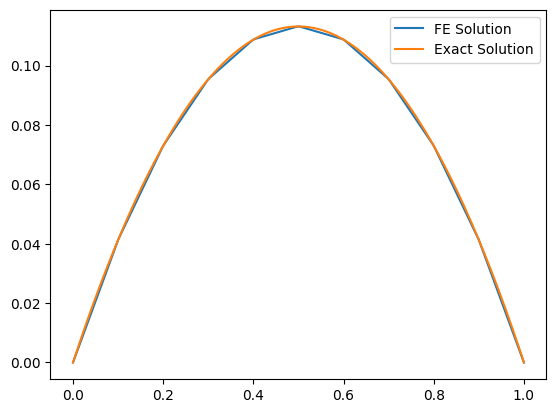

In [204]:
def u0(x):
    approx = 0
    for i in range(N):
        approx += U[i]*phi(i+1,x)
    return approx

def u_exact(x):
    e = np.e
    return ((1/e-1)/(e-1/e)*e**x-(e-1)/(e-1/e)*e**(-x))+1 # Solved analytically

xes = np.linspace(0,1,200)
plt.plot(xes, [u0(x) + u_hat(i,x) for x in xes], label = "FE Solution")
plt.plot(xes, [u_exact(x) for x in xes], label = "Exact Solution")
plt.legend()

If we include our piecewise quadratic basis functions too, then the dimension of our finite element space becomes $(N) + (N+1)$. To keep all our calculations of the stress matrix and load vector consistent with earlier, we can simply define a new function $\sigma$ that satisfies

$\sigma_i(x) =
\begin{cases}
    \phi_i, & \text{if } i \in \left[1,N\right] \\
    \psi_{i-N}, & \text{if } i \in \left[N+1,2N+1\right]
\end{cases}$

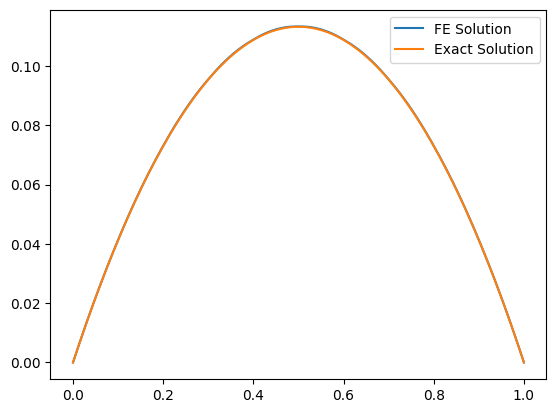

In [205]:
def sigma(i,x,deriv=False):
    if 1 <= i <= N:
        return phi(i,x,deriv=deriv)
    if N+1 <= i <= 2*N+1:
        return psi(i-N,x,deriv=deriv)

A = np.zeros((2*N+1, 2*N+1))
f_array = np.empty(2*N+1)

for i in range(1,2*N+2):
    A[i-1,i-1] = bilinear_form(sigma,i,sigma,i)

for i in range(1,2*N+1):
    A[i-1,i] = bilinear_form(sigma,i+1,sigma,i)
    A[i,i-1] = bilinear_form(sigma,i,sigma,i+1)

for i in range(1,2*N+2):
    f_array[i-1] = linear_functional(sigma,i) - bilinear_form(u_hat,i,sigma,i)

U = np.linalg.solve(A, f_array)

def u0(x):
    approx = 0
    for i in range(N):
        approx += U[i]*phi(i+1,x)
    for i in range(N+1):
        approx += U[i+N]*psi(i+1,x)
    return approx

def u_exact(x):
    e = np.e
    return ((1/e-1)/(e-1/e)*e**x-(e-1)/(e-1/e)*e**(-x))+1

xes = np.linspace(0,1,200)
plt.plot(xes, [u0(x) + u_hat(i,x) for x in xes], label = "FE Solution")
plt.plot(xes, [u_exact(x) for x in xes], label = "Exact Solution")
plt.legend()

# Neumann Boundary Conditions

Let $u'(0)=g_0$ and $u'(1)=g_1$

Let the finite element space $V_h$ be the piecewise linear functions in $H^1(0,1)$. It contains both basis functions $\phi_0$ and $\phi_{N+1}$ and has dimension $N+2$.

After calculating the weak form of the PDE, we find that our solution $u_h \in V_h$ will satisfy:

$$a(u_h,v) = l(v) \hspace{0.5cm} \forall v \in V_h$$

where

$$a(u,v)=\int_0^1 -a(x) u'v' +  b(x) u' v + c(x) u v \ dx$$
$$l(v) = \int_0^1 f(x)v \ dx - a(1)g_1v(1)+a(0)g_0v(0)$$

In [206]:
g0 = 2
g1 = 0

In [207]:
def bilinear_form(u,i,v,j):
    return integrate.quad(lambda x: -a(x)*u(i,x,deriv=True)*v(j,x,deriv=True) + b(x)*u(i,x,deriv=True)*v(j,x) + c(x)*u(i,x)*v(j,x), 0, 1)[0]

def linear_functional(v,i):
    return integrate.quad(lambda x: f(x)*v(i,x), 0, 1)[0]

A = np.zeros((N+2, N+2))
f_array = np.empty(N+2)

for i in range(N+2):
    A[i,i] = bilinear_form(phi,i,phi,i)

for i in range(N+1):
    A[i,i+1] = bilinear_form(phi,i+1,phi,i)
    A[i+1,i] = bilinear_form(phi,i,phi,i+1)

for i in range(N+2):
    f_array[i] = linear_functional(phi,i)

f_array[0] += a(0)*g0*phi(0,0) # Only phi_0 is non zero at x=0
f_array[N+1] += -a(1)*g1*phi(N+1,1) # Only phi_{N+1} is non zero at x=1

In [208]:
U = np.linalg.solve(A, f_array)
U

array([-1.62437358, -1.43718346, -1.27440587, -1.1344103 , -1.01579448,
       -0.91737024, -0.83815172, -0.77734541, -0.73434222, -0.70871141,
       -0.70019623])

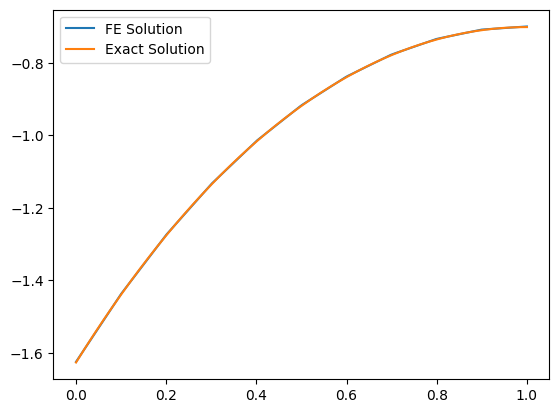

In [209]:
def u_h(x):
    approx = 0
    for i in range(N+2):
        approx += U[i]*phi(i,x)
    return approx

def u_exact(x):
    e = np.e
    return (2*e**(2*x)+(1-e**2)*e**x+2*e**2)*e**(-x)/(1-e**2)

xes = np.linspace(0,1,200)
plt.plot(xes, [u_h(x) for x in xes], label = "FE Solution")
plt.plot(xes, [u_exact(x) for x in xes], label = "Exact Solution")
plt.legend()

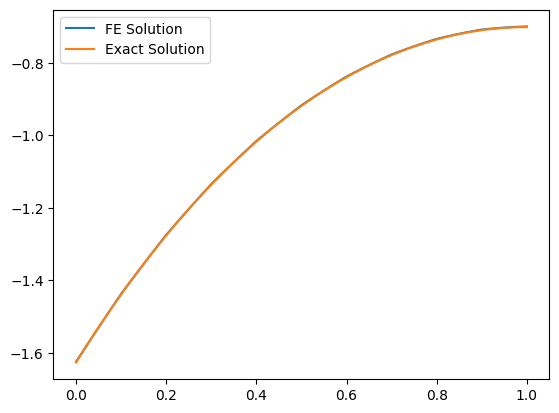

In [211]:
def sigma(i,x,deriv=False):
    if 0 <= i <= N+1:
        return phi(i,x,deriv=deriv)
    if N+2 <= i <= 2*N+2:
        return psi(i-(N+1),x,deriv=deriv)

A = np.zeros((2*N+3, 2*N+3))
f_array = np.empty(2*N+3)

for i in range(2*N+3):
    A[i,i] = bilinear_form(sigma,i,sigma,i)

for i in range(2*N+2):
    A[i,i+1] = bilinear_form(sigma,i+1,sigma,i) # Should be 0
    A[i+1,i] = bilinear_form(sigma,i,sigma,i+1) # Should be 0

for i in range(2*N+3):
    f_array[i] = linear_functional(sigma,i)

f_array[0] += a(0)*g0*phi(0,0) # Only phi_0 is non zero at x=0
f_array[N+1] += -a(1)*g1*phi(N+1,1) # Only phi_{N+1} is non zero at x=1

U = np.linalg.solve(A, f_array)

def u0(x):
    approx = 0
    for i in range(N+2):
        approx += U[i]*phi(i,x)
    for i in range(N+1):
        approx += U[i+N+2]*psi(i+1,x)
    return approx

def u_exact(x):
    e = np.e
    return (2*e**(2*x)+(1-e**2)*e**x+2*e**2)*e**(-x)/(1-e**2)

xes = np.linspace(0,1,200)
plt.plot(xes, [u0(x) for x in xes], label = "FE Solution")
plt.plot(xes, [u_exact(x) for x in xes], label = "Exact Solution")
plt.legend()

# Robin Boundary Conditions

Let $-u'(0) + \beta u(0) = -g_0$ and $u'(1) + \beta u(1) = g_1$ ($\beta > 0$)

Let the finite element space $V_h$ be the piecewise linear functions in $H^1(0,1)$. It contains both basis functions $\phi_0$ and $\phi_{N+1}$ and has dimension $N+2$.

After calculating the weak form of the PDE, we find that our solution $u_h \in V_h$ will satisfy:

$$a(u_h,v) = l(v) \hspace{0.5cm} \forall v \in V_h$$

where

$$a(u,v)=\int_0^1 -a(x) u'v' +  b(x) u' v + c(x) u v \ dx - a(1)\beta u(1)v(1) - a(0)\beta u(0)v(0)$$
$$l(v) = \int_0^1 f(x)v \ dx - a(1)g_1v(1) + a(0)g_0v(0)$$


In [143]:
g0=1
g1=0
beta=1

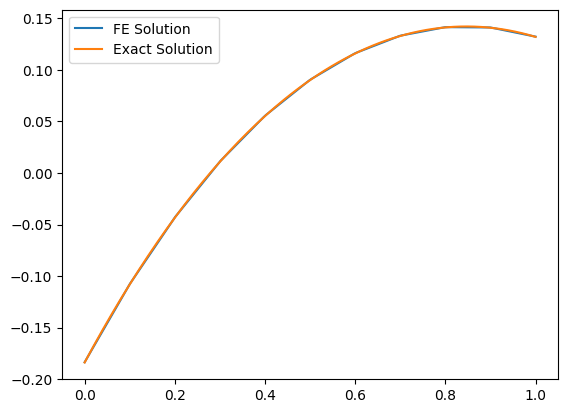

In [144]:
def bilinear_form(u,i,v,j):
    return integrate.quad(lambda x: -a(x)*u(i,x,deriv=True)*v(j,x,deriv=True) + b(x)*u(i,x,deriv=True)*v(j,x) + c(x)*u(i,x)*v(j,x), 0, 1)[0]

def linear_functional(v,i):
    return integrate.quad(lambda x: f(x)*v(i,x), 0, 1)[0]

A = np.zeros((N+2, N+2))
f_array = np.empty(N+2)

for i in range(N+2):
    A[i,i] = bilinear_form(phi,i,phi,i)

for i in range(N+1):
    A[i,i+1] = bilinear_form(phi,i+1,phi,i)
    A[i+1,i] = bilinear_form(phi,i,phi,i+1)

for i in range(N+2):
    f_array[i] = linear_functional(phi,i)

A[0,0] += -a(0)*beta*phi(0,0)*phi(0,0) # Only phi_0 is non zero at x=0
A[N+1,N+1] += - a(1)*beta*phi(N+1,1)*phi(N+1,1) # Only phi_{N+1} is non zero at x=1

f_array[0] += a(0)*g0*phi(0,0) # Only phi_0 is non zero at x=0
f_array[N+1] += -a(1)*g1*phi(N+1,1) # Only phi_{N+1} is non zero at x=1

U = np.linalg.solve(A, f_array)

def u_h(x):
    approx = 0
    for i in range(N+2):
        approx += U[i]*phi(i,x)
    return approx

def u_exact(x):
    e = np.e
    return -e**(x-1)/2-e**(-x)+1

xes = np.linspace(0,1,200)
plt.plot(xes, [u_h(x) for x in xes], label = "FE Solution")
plt.plot(xes, [u_exact(x) for x in xes], label = "Exact Solution")
plt.legend()

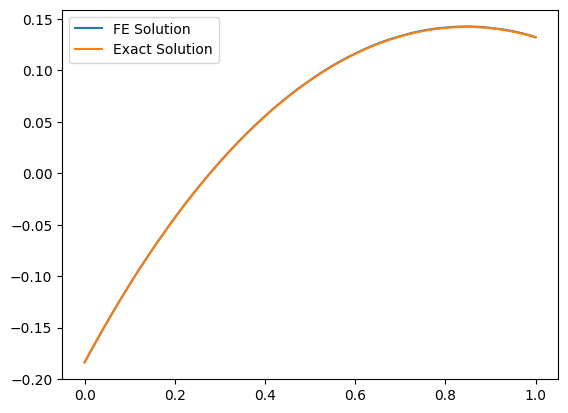

In [145]:
def sigma(i,x,deriv=False):
    if 0 <= i <= N+1:
        return phi(i,x,deriv=deriv)
    if N+2 <= i <= 2*N+2:
        return psi(i-(N+1),x,deriv=deriv)

A = np.zeros((2*N+3, 2*N+3))
f_array = np.empty(2*N+3)

for i in range(2*N+3):
    A[i,i] = bilinear_form(sigma,i,sigma,i)

for i in range(2*N+2):
    A[i,i+1] = bilinear_form(sigma,i+1,sigma,i) # Should be 0
    A[i+1,i] = bilinear_form(sigma,i,sigma,i+1) # Should be 0

for i in range(2*N+3):
    f_array[i] = linear_functional(sigma,i)

A[0,0] += -a(0)*beta*phi(0,0)*phi(0,0) # Only phi_0 is non zero at x=0
A[N+1,N+1] += - a(1)*beta*phi(N+1,1)*phi(N+1,1) # Only phi_{N+1} is non zero at x=1

f_array[0] += a(0)*g0*phi(0,0) # Only phi_0 is non zero at x=0
f_array[N+1] += -a(1)*g1*phi(N+1,1) # Only phi_{N+1} is non zero at x=1

U = np.linalg.solve(A, f_array)

def u0(x):
    approx = 0
    for i in range(N+2):
        approx += U[i]*phi(i,x)
    for i in range(N+1):
        approx += U[i+N+2]*psi(i+1,x)
    return approx

def u_exact(x):
    e = np.e
    return -e**(x-1)/2-e**(-x)+1

xes = np.linspace(0,1,200)
plt.plot(xes, [u0(x) for x in xes], label = "FE Solution")
plt.plot(xes, [u_exact(x) for x in xes], label = "Exact Solution")
plt.legend()

# Mixed Example - Dirichlet and Neumann

Let $u(0)=g_0$ and $u'(1)=g_1$

Let the finite element subspace $V_h$ be the piecewise linear functions in $H^1_{E_0}(0,1)$. It contains basis function $\phi_{N+1}$ but not $\phi_0$ and has dimension $N+1$.

Seek a solution in the form $u_h=u_0 + \hat{u}$ where $u_0 \in V_h$ and $\hat{u} \in H^1(0,1)$ satisfies the boundary conditions $\hat{u}(0) = g_0$.

An easy way to fulfill this condition is by defining: </br>

$\hat{u}(x) = g_0\phi_0$

</br>

After calculating the weak form of the PDE, we find that our solution will satisfy:

$$a(u_0,v) = l(v) - a(\hat{u},v)$$

where

$$a(u,v)=\int_0^1 -a(x) u'v' +  b(x) u' v + c(x) u v \ dx$$
$$l(v) = \int_0^1 f(x)v \ dx - a(1)g_1v(1)$$

In [38]:
g0 = 1
g1 = 3

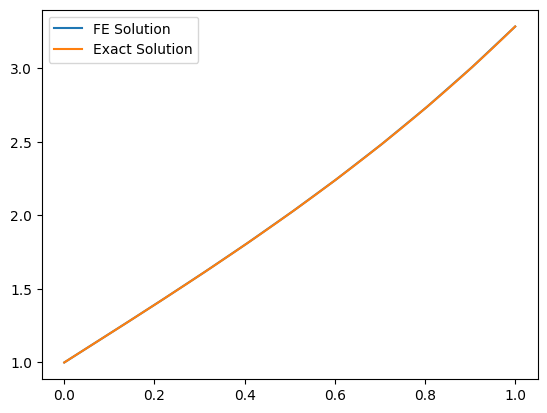

In [39]:
def bilinear_form(u,i,v,j):
    return integrate.quad(lambda x: -a(x)*u(i,x,deriv=True)*v(j,x,deriv=True) + b(x)*u(i,x,deriv=True)*v(j,x) + c(x)*u(i,x)*v(j,x), 0, 1)[0]

def linear_functional(v,i):
    return integrate.quad(lambda x: f(x)*v(i,x), 0, 1)[0]

def u_hat(i,x,deriv=False):
    if deriv == False:
        return g0*phi(0,x)
    if deriv:
        return g0*phi(0,x,deriv=True)

A = np.zeros((N+1, N+1))
f_array = np.empty(N+1)

for i in range(1,N+2):
    A[i-1,i-1] = bilinear_form(phi,i,phi,i)

for i in range(1,N+1):
    A[i-1,i] = bilinear_form(phi,i+1,phi,i)
    A[i,i-1] = bilinear_form(phi,i,phi,i+1)

for i in range(1,N+2):
    f_array[i-1] = linear_functional(phi,i) - bilinear_form(u_hat,i,phi,i)

f_array[N] += -a(1)*g1*phi(N+1,1) # Only phi_{N+1} is non zero at x=1

U = np.linalg.solve(A, f_array)

def u0(x):
    approx = 0
    for i in range(N+1):
        approx += U[i]*phi(i+1,x)
    return approx

def u(x):
    e=np.e
    return (-3*e**(1-x)+3*e**(x+1)+1+e**2)/(1+e**2)

xes = np.linspace(0,1,200)
plt.plot(xes, [u0(x) + u_hat(i,x) for x in xes], label = "FE Solution")
plt.plot(xes, [u(x) for x in xes], label = "Exact Solution")
plt.legend()


Similarly for $u'(0)=g_0$ and $u(1)=g_1$

In [40]:
g0 = 2
g1 = 5

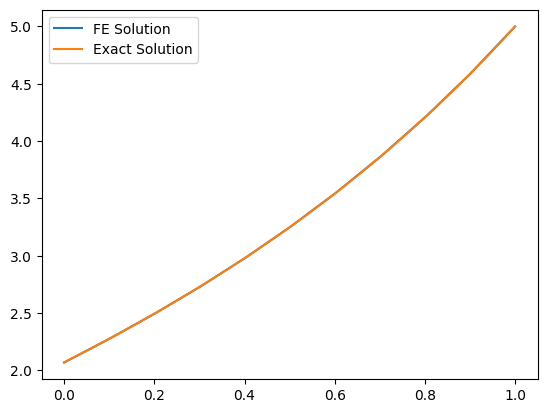

In [42]:
def bilinear_form(u,i,v,j):
    return integrate.quad(lambda x: -a(x)*u(i,x,deriv=True)*v(j,x,deriv=True) + b(x)*u(i,x,deriv=True)*v(j,x) + c(x)*u(i,x)*v(j,x), 0, 1)[0]

def linear_functional(v,i):
    return integrate.quad(lambda x: f(x)*v(i,x), 0, 1)[0]

def u_hat(i,x,deriv=False):
    if deriv == False:
        return g1*phi(N+1,x)
    if deriv:
        return g1*phi(N+1,x,deriv=True)

A = np.zeros((N+1, N+1))
f_array = np.empty(N+1)

for i in range(N+1):
    A[i,i] = bilinear_form(phi,i,phi,i)

for i in range(N):
    A[i,i+1] = bilinear_form(phi,i+1,phi,i)
    A[i+1,i] = bilinear_form(phi,i,phi,i+1)

for i in range(N+1):
    f_array[i] = linear_functional(phi,i) - bilinear_form(u_hat,i,phi,i)

f_array[0] += a(0)*g0*phi(0,0)  # Only phi_0 is non zero at x=0

U = np.linalg.solve(A, f_array)

def u0(x):
    approx = 0
    for i in range(N+1):
        approx += U[i]*phi(i,x)
    return approx

def u(x):
    return 2*(1+2*np.e)*np.e**x/(1+np.e**2)+(2-np.e)*np.e**(-x)/(np.cosh(1)) + 1

xes = np.linspace(0,1,200)
plt.plot(xes, [u0(x) + u_hat(i,x) for x in xes], label = "FE Solution")
plt.plot(xes, [u(x) for x in xes], label = "Exact Solution")
plt.legend()

# Conclusion

The method does not differ largely depending on the boundary condition used. If we take the base problem as the Homogenous Dirichlet ODE, then the following conditions at one of the boundaries will require the following adjustments:

*   **Inhomogenous Dirichlet:** Let $\hat{u} \in V_h$ satisfy the boundary conditions. You must add one term in the form $- a(\hat{u},v)$ to the load vector.
*   **Neumann:** You must add a term to one entry of the load vector. ($- a(1)g_1v(1)$ or $a(0)g_0v(0)$)
*   **Robin:** You must add a term to one entry of the load vector and one entry of the stress matrix ($- a(\cdot)\beta u(\cdot)v(\cdot)$).

Since these are all linear operations, then combining any two different conditions will be straightforward.


If you want to explore the implementation of the Finite Element Method further and at a deeper level, then I recommend visiting the open source project https://fenicsproject.org. The [**FEniCS documentation**](https://docs.fenicsproject.org/dolfinx/v0.8.0/python/demos.html) has very similar notation to Professor Iain's Variational Methods course.

## Thank you.
Notebook created by Avanish Meedimale (https://github.com/AvanishMeedimale)